0. AZURE STORAGE CONFIG

In [0]:
import os
storage_account_name = "gasprojectsadl"
processed_data_container = "processed-data"
storage_key = dbutils.secrets.get(scope="gas-project-scope", key="gasprojectsadl-key")

mount_point = f"/mnt/{processed_data_container}"
if not any(mount.mountPoint == mount_point for mount in dbutils.fs.mounts()):
  dbutils.fs.mount(
    source=f"wasbs://{processed_data_container}@{storage_account_name}.blob.core.windows.net/",
    mount_point=mount_point,
    extra_configs={f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net": storage_key},
  )
  print(f"Mount point {mount_point} created.")
else:
  print(f"Mount point {mount_point} already exists.")

csv_folder_path = f"/dbfs{mount_point}/final_ea_ldz_master_csv/"
try:
    csv_file = [f for f in os.listdir(csv_folder_path) if f.endswith('.csv')][0]
    master_data_path_dbfs = os.path.join(csv_folder_path, csv_file)
    print(f"Master data file path is ready: {master_data_path_dbfs}")
except IndexError:
    print(f"ERROR: No CSV file found in the directory: {csv_folder_path}")

PROCESSED_MOUNT = mount_point               
PROCESSED_LOCAL = f"/dbfs{mount_point}"

csv_folder_path = f"{PROCESSED_LOCAL}/final_ea_ldz_master_csv/"


Mount point /mnt/processed-data already exists.
Master data file path is ready: /dbfs/mnt/processed-data/final_ea_ldz_master_csv/master_ea_ldz.csv

1. GAS MODEL CLASS DEFINITION

In [0]:
# Core Python Packages
import os
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from contextlib import nullcontext
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from pathlib import Path
from datetime import datetime
import tempfile
import contextlib
import matplotlib.pyplot as plt

try:
    import mlflow
    import mlflow.keras
    try:
        import mlflow.statsmodels
        _HAS_SM_FLAVOR = True
    except Exception:
        _HAS_SM_FLAVOR = False
    _MLFLOW_AVAILABLE = True
except ImportError:
    mlflow = None
    _HAS_SM_FLAVOR = False
    _MLFLOW_AVAILABLE = False

warnings.filterwarnings("ignore")


class GasModel:
    def __init__(self, data_path=None, dataframe=None):
        """
        Initialize the GasModel with optional data source.
        """
        if data_path:
            self.df = pd.read_csv(data_path, parse_dates=True, index_col=0)
        elif dataframe is not None:
            self.df = dataframe.copy()
        else:
            self.df = None

        self.model = None
        self.history = {}
        self.target_col = None
        self.df_prepared = None
        self.exog_cols = None
        self.exog_future = pd.DataFrame()
        self.future_forecast_series = None
        self.processed_root = PROCESSED_LOCAL
        self._active_model_name = None

    ##################################################
    # MLflow and artifact logging run helper
    ##################################################

    def _mlflow_run(self, enabled: bool, run_name: str): 
        
        """Return an active MLflow run context if enabled; otherwise a no-op context.""" 
        if enabled: 
            if not _MLFLOW_AVAILABLE: 
                raise ImportError("use_mlflow=True but MLflow isn't installed. Please pip install mlflow.\n") 
            return mlflow.start_run(run_name=run_name) 
        return nullcontext()
    
    def _safe_mkdir(self, p: Path) -> Path:
        p.mkdir(parents=True, exist_ok=True)
        return p

    def _active_run_stub(self) -> str:
        """Return a short run identifier (MLflow run_id[:8] if available, else timestamp)."""
        rid = None
        if _MLFLOW_AVAILABLE:
            try:
                run = mlflow.active_run()
                if run:
                    rid = run.info.run_id[:8]
            except Exception:
                pass
        return rid or datetime.now().strftime("%Y%m%d-%H%M%S")

    def _run_subdir(self) -> Path:

        model = self._active_model_name or "MODEL"
        return Path(self.processed_root) / f"{model}-{self._active_run_stub()}"

    def _log_df_and_plot(self, df, fig, base_name: str):

        root = self._run_subdir()
        data_dir = self._safe_mkdir(root / "data")
        plot_dir = self._safe_mkdir(root / "plots")

        csv_path = data_dir / f"{base_name}.csv"
        df.to_csv(csv_path, index=False)
        if _MLFLOW_AVAILABLE:
            try:
                mlflow.log_artifact(str(csv_path), artifact_path="data")
            except Exception as e:
                print(f"MLflow log_artifact(data) failed: {e}")

        png_path = plot_dir / f"{base_name}.png"
        fig.savefig(png_path, bbox_inches="tight", dpi=150)
        if _MLFLOW_AVAILABLE:
            try:
                mlflow.log_artifact(str(png_path), artifact_path="plots")
            except Exception as e:
                print(f"MLflow log_artifact(plots) failed: {e}")
    
    def _log_metrics(self, metrics: dict, base_name: str = "eval_metrics"):
        """
        Save metrics locally and to MLflow.
        Local:  processed-data/<MODEL>-<runid>/metrics/<base_name>.{csv,json}
        MLflow: log_metric(...) and log_artifact(...) under artifacts/metrics/
        """
        # local save
        root = self._run_subdir()
        met_dir = self._safe_mkdir(root / "metrics")
        json_path = met_dir / f"{base_name}.json"
        csv_path  = met_dir / f"{base_name}.csv"

        with open(json_path, "w") as f:
            json.dump(metrics, f, indent=2)
        pd.DataFrame([metrics]).to_csv(csv_path, index=False)

        # mlflow
        if _MLFLOW_AVAILABLE:
            try:
                # log individual metrics
                for k, v in metrics.items():
                    try:
                        mlflow.log_metric(k, float(v), step=step)
                    except Exception:
                        pass
                # also keep a copy of the files under artifacts/metrics
                mlflow.log_artifact(str(json_path), artifact_path="metrics")
                mlflow.log_artifact(str(csv_path),  artifact_path="metrics")
            except Exception as e:
                print(f"MLflow metric logging failed: {e}")

    def mirror_artifacts_to_datalake(self, dest_base_uri: str = "dbfs:/mnt/processed-data/mlflow"):

        if not _MLFLOW_AVAILABLE:
            print("MLflow not available; skipping mirror.")
            return

        run = mlflow.active_run()
        if run is None:
            print("No active MLflow run; skipping mirror.")
            return
        
        src_root = mlflow.get_artifact_uri()
        short_id = run.info.run_id[:8]
        model = (self._active_model_name or "MODEL").upper()
        dest_uri = f"{dest_base_uri.rstrip('/')}/{model}-{short_id}"

        try:
            dbutils.fs.mkdirs(dest_uri)
            dbutils.fs.cp(src_root, dest_uri, recurse=True)
            print(f"Mirrored MLflow artifacts → {dest_uri}")
        except Exception as e:
            print(f"Could not mirror MLflow artifacts: {e}")


    #################
    # COMMON METHODS
    #################
    def fix_nan_dataset(self, file_path):
        df = pd.read_csv(file_path)
        df_fixed = df.copy()

        excluded_indices = df[
            df["Demand_D+1"].isnull() | df["Demand_D+6"].isnull()
        ].index

        demand_cols = ["Demand_D+1", "Demand_D+6"]
        d_cols = [
            col
            for col in df.columns
            if any(token in col for token in ["D+1", "D", "D-1"]) and col not in demand_cols
        ]
        non_d_cols = [col for col in df.columns if col not in d_cols + demand_cols]

        for col in d_cols:
            missing_idx = df.index[df[col].isnull() & ~df.index.isin(excluded_indices)]

            for idx in missing_idx:

                for alt_col in d_cols:
                    if alt_col != col and pd.notnull(df.at[idx, alt_col]):
                        df_fixed.at[idx, col] = df.at[idx, alt_col]
                        break

        for col in non_d_cols:
            missing_idx = df.index[df[col].isnull() & ~df.index.isin(excluded_indices)]

            for idx in missing_idx:
                prev_idx = idx - 1
                next_idx = idx + 1

                while prev_idx >= 0 and pd.isnull(df.at[prev_idx, col]):
                    prev_idx -= 1

                while next_idx < len(df) and pd.isnull(df.at[next_idx, col]):
                    next_idx += 1

                prev_val = df.at[prev_idx, col] if prev_idx >= 0 else np.nan
                next_val = df.at[next_idx, col] if next_idx < len(df) else np.nan

                if pd.notnull(prev_val) and pd.notnull(next_val):
                    df_fixed.at[idx, col] = (prev_val + next_val) / 2
                elif pd.notnull(prev_val):
                    df_fixed.at[idx, col] = prev_val
                elif pd.notnull(next_val):
                    df_fixed.at[idx, col] = next_val

        return df_fixed

    def load_and_split_data(
        self,
        file_path,
        target="Demand_D+1",
        split_ratio=0.8,
        fix_nan=False,
        target_shift=0,
        apply_supervised=False,):

        if fix_nan:
            df = self.fix_nan_dataset(file_path)
        else:
            df = pd.read_csv(file_path)

        df['Applicable For'] = pd.to_datetime(df['Applicable For'])
        df.set_index("Applicable For", inplace=True)

        if target not in df.columns:
            raise ValueError(f"Target column '{target}' not found.")

        if apply_supervised:
            df, _, _ = self.prepare_lstm_supervised(df, target=target, target_shift=target_shift)

        total_len = len(df)
        train_len = int(total_len * split_ratio)

        df_train_raw = df.iloc[:train_len]
        df_test_raw = df.iloc[train_len:]

        train_df = df_train_raw.dropna()
        test_df = df_test_raw.dropna()

        future_df = df_test_raw[df_test_raw[target].isna()]

        self.df = df
        self.train_df_3df = train_df
        self.test_df_3df = test_df
        self.future_df_3df = future_df
        self.target_col = target

        print("Data Summary (target = {})".format(target))
        print(f"Train Range : {train_df.index.min()} to {train_df.index.max()} ({len(train_df)} rows)")
        print(f"Test Range  : {test_df.index.min()} to {test_df.index.max()} ({len(test_df)} rows)")

        if len(future_df) > 0:
            print(f"Future Forecast Range : {future_df.index.min()} to {future_df.index.max()} ({len(future_df)} rows)")
        else:
            print("Future Forecast Range : 0 Rows")

        return train_df, test_df, future_df

    def find_best_order(self, seasonal=True, m=7):

        if self.df_prepared is None or self.target_col is None:
            raise ValueError("Call load_and_split_data() before find_best_order().")

        print("Running auto_arima...")
        model = auto_arima(
            self.df_prepared[self.target_col],
            exogenous=self.df_prepared[self.exog_cols] if self.exog_cols else None,
            seasonal=seasonal,
            m=m,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
        )
        print("Best order:", model.order)
        print("Best seasonal order:", model.seasonal_order)
        return model.order, model.seasonal_order

    def normalize_data(self, df, feature_cols, target_col):
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_scaled = scaler_X.fit_transform(df[feature_cols])
        y_scaled = scaler_y.fit_transform(df[[target_col]])

        return X_scaled, y_scaled, scaler_X, scaler_y

    def denormalize_data(self, preds_scaled, scaler_y):
        return scaler_y.inverse_transform(preds_scaled)

    def create_sequences(self, X, y, sequence_length=30):
        X_seq, y_seq = [], []
        for i in range(sequence_length, len(X)):
            X_seq.append(X[i - sequence_length : i])
            y_seq.append(y[i])
        return np.array(X_seq), np.array(y_seq)

    def prepare_lstm_supervised(self, df, target, target_shift=0):
        df = df.copy()
        additional_features = []

        if not pd.api.types.is_datetime64_any_dtype(df.index):
            if 'Applicable For' in df.columns:
                df['Applicable For'] = pd.to_datetime(df['Applicable For'])
                df.set_index('Applicable For', inplace=True)
            else:
                raise ValueError("Datetime index or 'Applicable For' column required.")

        if target_shift > 0:
            df['Target_Shift_Ac'] = df[target].shift(target_shift)
            additional_features.append('Target_Shift_Ac')
            df['day_of_week'] = df.index.dayofweek
            df['month_of_year'] = df.index.month
            additional_features.extend(['day_of_week', 'month_of_year'])

        # Return
        y = df[target]
        return df, y, additional_features

    def evaluate_model(self, y_true, y_pred, title="Model Evaluation", log_to_mlflow=False):

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)

        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2f}")

        plt.figure(figsize=(12, 4))
        plt.plot(y_true, label="Actual")
        plt.plot(y_pred, label="Predicted")
        plt.title(title)
        plt.grid(True)
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()

        #MLflow logging
        if log_to_mlflow and _MLFLOW_AVAILABLE:
            mlflow.log_metrics({
                "mae": float(mae),
                "rmse": float(rmse),
                "mape": float(mape),
            })
            safe_name = title.replace(" ", "_").lower() + ".png"
            mlflow.log_figure(plt.gcf(), f"plots/{safe_name}")
    
        try:
            idx = getattr(y_true, "index", pd.RangeIndex(len(y_true)))
            plot_df = pd.DataFrame({
                "timestamp": pd.Index(idx),
                "actual": np.asarray(y_true).reshape(-1),
                "pred":   np.asarray(y_pred).reshape(-1),
            })

            self._log_df_and_plot(df=plot_df, fig=plt.gcf(), base_name="forecast_vs_actual")
        except Exception as e:
            print(f"Saving plot data failed (forecast_vs_actual): {e}")
        
        metrics = {"mae": float(mae), "rmse": float(rmse), "mape": float(mape)}
        self._log_metrics(metrics, base_name="evaluation")

        plt.show()
        return {"mae": float(mae), "rmse": float(rmse), "mape": float(mape)}

    def forecast_future(self,model=None,steps=None,exog_future=None,future_forecast_series=None,log_to_mlflow: bool = False,):

        if self.model is None:
            raise ValueError("No trained model found.")

        if hasattr(self.model, "forecast"):
            if exog_future is None:
                exog_future = self.exog_future

            if exog_future is None or exog_future.empty:
                raise ValueError("No future exogenous data provided.")

            steps = steps or len(exog_future)
            # Forecast calculation
            forecast = self.model.forecast(steps=steps, exog=exog_future)
            print(exog_future.index)
            forecast.index = exog_future.index[:steps]
            print(f"Forecast Values :- ")
            print(forecast)

        else:
            # for LSTM
            if not hasattr(self, "future_forecast_series") or self.future_forecast_series is None:
                raise ValueError("No LSTM future forecast found. Train LSTM with forecast_after_train=True.")
            forecast = self.future_forecast_series
            steps = len(forecast)

        forecast_start_date = forecast.index.min()
        recent_actuals = self.df[self.target_col].dropna()
        recent_actuals = recent_actuals[recent_actuals.index < forecast_start_date].iloc[-steps:]
        print(f"Recent Values :- ")
        print(recent_actuals)

        # Ensure recent_actuals is a Series
        recent_actuals = recent_actuals.rename("value")
        recent_actuals = recent_actuals.to_frame()
        recent_actuals["type"] = "Actual"
        # Ensure forecast is a Series
        forecast = forecast.rename("value")
        forecast = forecast.to_frame()
        forecast["type"] = "Forecast"

        # Combine into one DataFrame
        plot_df = pd.concat([recent_actuals, forecast])
        # Reindex to continuous daily dates
        full_index = pd.date_range(start=plot_df.index.min(), end=plot_df.index.max(), freq='D')
        plot_df = plot_df.reindex(full_index)
        # Fill missing 'type' if needed
        plot_df["type"] = plot_df["type"].fillna(method="ffill")
                
        plt.figure(figsize=(12, 4))

        # Plot each type with separate color/linestyle
        for label, df in plot_df.groupby("type"):
            plt.plot(
                df.index,
                df["value"],
                label=label,
                linestyle="--" if label == "Forecast" else "-",
                color="orange" if label == "Forecast" else "royalblue",
            )
        plt.plot(
            [recent_actuals.index[-1], forecast.index[0]],
            [recent_actuals["value"].iloc[-1], forecast["value"].iloc[0]],
            linestyle='--',
            color='orange',
        )

        import matplotlib.dates as mdates
        date_fmt = mdates.DateFormatter('%d-%m-%Y')
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.title(f"Next {len(forecast)}-Day Forecast for {self.target_col}")
        plt.xlabel("Date")
        plt.ylabel(self.target_col)
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.legend()

        #Save artifacts
        try:
            next_df = forecast.reset_index().rename(columns={
                forecast.index.name or "index": "timestamp",
                "value": "forecast",
            })
            self._log_df_and_plot(df=next_df, fig=plt.gcf(), base_name="next_n_days")

            recent_and_forecast = plot_df.reset_index().rename(columns={"index": "timestamp"})
            
            self._log_df_and_plot(df=recent_and_forecast, fig=plt.gcf(), base_name="recent_and_forecast")
        except Exception as e:
            print(f"[warn] Saving plot data failed: {e}")

        #MLflow logging#
        if log_to_mlflow and _MLFLOW_AVAILABLE:
            mlflow.log_figure(plt.gcf(), "plots/forecast.png")

        return forecast

    ##################################
    # SARIMAX TRAINING / FORECASTING
    ##################################
    def train_sarimax(
        self,
        order=None,
        seasonal_order=None,
        exog_vars=None,
        auto=False,
        seasonal=True,
        m=7,
        ac_fo_mode=False,
        split_ratio=0.8,
        file_path=None,
        target="Demand_D+1",
        fix_nan=False,
        forecaster_after_train=True,
        use_mlflow=False,
        flow_num=None,
        tag=None):
        """
        Train a SARIMAX model using one of 4 scenarios.
        If use_mlflow=True, logs params/metrics/plots/model to MLflow.
        """
        run_name = f"SARIMAX_{target}_{tag}_Run_{flow_num}"
        with self._mlflow_run(use_mlflow, run_name):
            self._active_model_name = "SARIMAX"
            
            train_df, test_df, future_df = self.load_and_split_data(
                file_path=file_path,
                target=target,
                split_ratio=split_ratio,
                fix_nan=fix_nan,
            )

            #mflow logging parameters
            if use_mlflow and _MLFLOW_AVAILABLE:
                mlflow.set_tags({
                    "framework": "statsmodels",
                    "mode": "AC/FO" if ac_fo_mode else "SameExog",
                })
                mlflow.log_dict(
                    {
                        "train_rows": int(len(train_df)),
                        "test_rows": int(len(test_df)),
                        "future_rows": int(len(future_df)),
                        "train_start": str(train_df.index.min()),
                        "train_end": str(train_df.index.max()),
                        "test_start": str(test_df.index.min()),
                        "test_end": str(test_df.index.max()),
                    },
                    "data/summary.json",
                )
                mlflow.log_params(
                    {
                        "model_type": "SARIMAX",
                        "target": target,
                        "split_ratio": split_ratio,
                        "fix_nan": fix_nan,
                        "auto_order": auto,
                        "seasonal": seasonal,
                        "m": m,
                        "ac_fo_mode": ac_fo_mode,
                        "exog_vars_ac": ",".join(exog_vars['ac'])
                        if ac_fo_mode and exog_vars and 'ac' in exog_vars
                        else "",
                        "exog_vars_fo": ",".join(exog_vars['fo'])
                        if ac_fo_mode and exog_vars and 'fo' in exog_vars
                        else "",
                        "exog_vars_same": ",".join(exog_vars)
                        if (not ac_fo_mode and exog_vars)
                        else "",
                    }
                )

            if ac_fo_mode:
                # separate AC (train) and FO (test/future)
                exog_train = (
                    train_df[exog_vars['ac']] if exog_vars and 'ac' in exog_vars else None
                )
                exog_test = (
                    test_df[exog_vars['fo']] if exog_vars and 'fo' in exog_vars else None
                )
                exog_future = (
                    future_df[exog_vars['fo']]
                    if exog_vars and 'fo' in exog_vars and not future_df.empty
                    else pd.DataFrame()
                )
                self.exog_cols = exog_vars['ac'] if exog_vars and 'ac' in exog_vars else None
                print(f"Exog Train (AC): {exog_train}")
                print(f"Exog Test (FO): {exog_test}")
                print(f"Exog Future (FO): {exog_future}")

            else:
                # same exog variables for train/test/future
                exog_train = train_df[exog_vars] if exog_vars else None
                exog_test = test_df[exog_vars] if exog_vars else None
                exog_future = (
                    future_df[exog_vars] if exog_vars and not future_df.empty else pd.DataFrame()
                )
                self.exog_cols = exog_vars
                print(f"Exog Train: {exog_train}")
                print(f"Exog Test: {exog_test}")
                print(f"Exog Future: {exog_future}")

            #Cleaning
            y_train = train_df[target]
            y_test = test_df[target]
            if exog_train is not None:
                valid_idx = exog_train.dropna().index.intersection(y_train.dropna().index)
                exog_train = exog_train.loc[valid_idx]
                y_train = y_train.loc[valid_idx]

            #store for internal use
            self.target_col = target
            self.df_prepared = train_df
            self.exog_future = exog_future

            #auto arima order
            if auto:
                order, seasonal_order = self.find_best_order(seasonal=seasonal, m=m)
                if use_mlflow and _MLFLOW_AVAILABLE:
                    mlflow.log_params({
                        "order": str(order),
                        "seasonal_order": str(seasonal_order),
                    })

            #fit and training model
            self.model = (
                SARIMAX(
                    endog=y_train,
                    exog=exog_train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    measurement_error=False,
                ).fit(disp=False)
            )

            print("SARIMAX model trained.")

            # STEP 6: Predict and evaluate using test set
            preds = self.model.predict(
                start=len(y_train),
                end=len(y_train) + len(y_test) - 1,
                exog=exog_test,
            )
            # Fix index misalignment
            preds.index = y_test.index
            self.evaluate_model(
                y_test,
                preds,
                title="SARIMAX Test Evaluation",
                log_to_mlflow=use_mlflow and _MLFLOW_AVAILABLE,
            )

            # STEP 7: Log model (optional)
            if use_mlflow and _MLFLOW_AVAILABLE:
                try:
                    if _HAS_SM_FLAVOR:
                        mlflow.statsmodels.log_model(self.model, name="model")
                    else:
                        with open("sarimax.pkl", "wb") as f:
                            pickle.dump(self.model, f)
                        mlflow.log_artifact("sarimax.pkl", artifact_path="model")
                except Exception as e:
                    print(f"MLflow model logging failed: {e}")

            # STEP 8: Future forecast using general plotting method
            if forecaster_after_train and not self.exog_future.empty:
                self.forecast_future(
                    model=self.model,
                    steps=len(self.exog_future),
                    exog_future=self.exog_future,
                    log_to_mlflow=use_mlflow and _MLFLOW_AVAILABLE,
                )

            if use_mlflow and _MLFLOW_AVAILABLE:
               self.mirror_artifacts_to_datalake("dbfs:/mnt/processed-data/mlflow")
            
        return self.model, preds, self.exog_future
    
    
    ##################################
    # Deep Learning Models TRAINING AND FORECASTING
    ##################################
    def train_dlm(
        self,
        file_path,
        target,
        DLM="LSTM",
        target_shift=0,
        feature_cols=None,
        split_ratio=0.8,
        sequence_length=30,
        units=64,
        epochs=20,
        batch_size=32,
        dense=1,
        random_seed=42,
        forecast_after_train=True,
        fix_nan=False,
        optimizer="adam",
        loss="mse",
        use_mlflow=False,
        flow_num=None,
        tag=None,):
        """
        Unified Deep Learning Model (DLM) trainer for sequence models.
        Chooses between LSTM / SimpleRNN / GRU based on `DLM`.
        Mirrors the behavior of train_lstm/train_rnn/train_gru.
        """
        # ---- choose recurrent layer ----
        from tensorflow.keras.layers import LSTM as _LSTM, SimpleRNN as _RNN, GRU as _GRU
        
        if isinstance(DLM, str):
            key = DLM.strip().upper()
            layer_map = {"LSTM": _LSTM, "RNN": _RNN, "GRU": _GRU}
            if key not in layer_map:
                raise ValueError(f"DLM must be one of {{'LSTM','RNN','GRU'}} or a Keras layer class. Got: {DLM}")
            layer_cls = layer_map[key]
        else:
            # Allow passing an actual Keras layer class (e.g., GRU)
            layer_cls = DLM
            key = getattr(layer_cls, "__name__", "DLM")

        # ---- seeding ----
        np.random.seed(random_seed)
        random.seed(random_seed)
        tf.random.set_seed(random_seed)

        # ---- MLflow run name ----
        run_name = f"{key}_{target}_{tag}_Run_{flow_num}"
        with self._mlflow_run(use_mlflow, run_name):
            self._active_model_name = key
            # ---- load & split ----
            train_df, test_df, future_df = self.load_and_split_data(
                file_path=file_path,
                target=target,
                split_ratio=split_ratio,
                fix_nan=fix_nan,
                target_shift=target_shift,
                apply_supervised=True,
            )
            df = pd.concat([train_df, test_df])

            if feature_cols is None:
                raise ValueError("You must provide feature_cols list.")

            # ---- MLflow metadata ----
            if use_mlflow and _MLFLOW_AVAILABLE:
                mlflow.set_tags({"framework": "keras"})
                mlflow.log_dict(
                    {
                        "train_rows": int(len(train_df)),
                        "test_rows": int(len(test_df)),
                        "future_rows": int(len(future_df)),
                        "train_start": str(train_df.index.min()),
                        "train_end": str(train_df.index.max()),
                        "test_start": str(test_df.index.min()),
                        "test_end": str(test_df.index.max()),
                    },
                    "data/summary.json",
                )
                mlflow.log_params(
                    {
                        "model_type": key,
                        "target": target,
                        "split_ratio": split_ratio,
                        "sequence_length": sequence_length,
                        "units": units,
                        "epochs": epochs,
                        "batch_size": batch_size,
                        "dense": dense,
                        "optimizer": optimizer,
                        "loss": loss,
                        "target_shift": target_shift,
                        "fix_nan": fix_nan,
                        "random_seed": random_seed,
                        "feature_cols": ",".join(feature_cols) if feature_cols else "",
                    }
                )

            # ---- engineered features (when shifting) ----
            engineered_if_shift = (
                ["Target_Shift_Ac", "day_of_week", "month_of_year"] if target_shift > 0 else []
            )
            feature_cols = feature_cols + [
                f for f in engineered_if_shift if f not in feature_cols and f in df.columns
            ]

            print(f"Final features used in {key}:", feature_cols)
            print("DataFrame columns before normalization", df.columns.tolist())

            df = df.dropna(subset=feature_cols + [target])

            # ---- scale + sequences ----
            X_scaled, y_scaled, scaler_X, scaler_y = self.normalize_data(df, feature_cols, target)
            X_seq, y_seq = self.create_sequences(X_scaled, y_scaled, sequence_length)

            split = int(len(X_seq) * split_ratio)
            X_train, X_test = X_seq[:split], X_seq[split:]
            y_train, y_test = y_seq[:split], y_seq[split:]

            # ---- build model ----
            model = Sequential()
            model.add(layer_cls(units, input_shape=(sequence_length, len(feature_cols))))
            model.add(Dense(dense))
            model.compile(optimizer=optimizer, loss=loss)

            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

            # ---- eval ----
            y_pred = model.predict(X_test)
            y_pred_inv = self.denormalize_data(y_pred, scaler_y)
            y_test_inv = self.denormalize_data(y_test, scaler_y)

            test_index = df.index[-len(y_test_inv):]
            y_test_inv_series = pd.Series(y_test_inv.flatten(), index=test_index)
            y_pred_inv_series = pd.Series(y_pred_inv.flatten(), index=test_index)

            self.evaluate_model(
                y_test_inv_series,
                y_pred_inv_series,
                title=f"{key} Forecast vs Actual",
                log_to_mlflow=use_mlflow and _MLFLOW_AVAILABLE,
            )

            # ---- save state for future forecasting ----
            self.model = model
            self.scaler_X = scaler_X
            self.scaler_y = scaler_y
            self.sequence_length = sequence_length
            self.feature_cols = feature_cols
            self.target_col = target

            # ---- future forecast ----
            if forecast_after_train and not self.future_df_3df.empty:
                print("\nFuture data available. Predicting future values...")

            context_df = pd.concat(
                [df.iloc[-self.sequence_length :], self.future_df_3df]
            )

            X_future_scaled = self.scaler_X.transform(context_df[self.feature_cols])
            X_future_seq, _ = self.create_sequences(
                X_future_scaled, np.zeros(len(X_future_scaled)), self.sequence_length
            )
            y_future_scaled = self.model.predict(X_future_seq)
            y_future = self.denormalize_data(y_future_scaled, self.scaler_y)

            forecast_index = self.future_df_3df.index[: len(y_future)]
            future_forecast = pd.Series(y_future.flatten(), index=forecast_index)

            print(f"{key} Future Forecast:")
            print(future_forecast)

            self.future_forecast_series = future_forecast

            if forecast_after_train:
                self.forecast_future(
                    model=self.model,
                    future_forecast_series=future_forecast,
                    log_to_mlflow=use_mlflow and _MLFLOW_AVAILABLE,
                )

            # ---- log model artifact ----
            if use_mlflow and _MLFLOW_AVAILABLE:
                try:
                    # NOTE: use artifact_path (correct) rather than name=
                    mlflow.keras.log_model(self.model, artifact_path="model")
                except Exception as e:
                    print(f"MLflow Keras model logging failed: {e}")

                        
            if use_mlflow and _MLFLOW_AVAILABLE:
                # send this run’s artifacts to the lake
                self.mirror_artifacts_to_datalake("dbfs:/mnt/processed-data/mlflow")

            return self, model, scaler_X, scaler_y, future_forecast

   

CALL RNN MODEL

Data Summary (target = Demand_D+1)
Train Range : 2020-07-21 00:00:00 to 2024-07-19 00:00:00 (1460 rows)
Test Range : 2024-07-20 00:00:00 to 2025-07-15 00:00:00 (361 rows)
Future Forecast Range : 2025-07-21 00:00:00 to 2025-07-22 00:00:00 (2 rows)
Final features used in RNN: ['Temp_Fo_D-1(C)', 'CWV_D-1', 'Target_Shift_Ac', 'day_of_week', 'month_of_year']
DataFrame columns before normalization ['Demand_D+1', 'Demand_D+6', 'Calorific_Value', 'CWV_D-1', 'CWV_D', 'CWV_D+1', 'SAP_Actual_Day', 'SAP_Highest_18', 'SAP_7D_RAVG', 'SAP_30D_RAVG', 'Temp_Ac_D+1(C)', 'Temp_Fo_D(C)', 'Temp_Fo_D-1(C)', 'Temp_SN_D(C)', 'Temp_SN_D+1(C)', 'Temp_SN_D-1(C)', 'Target_Shift_Ac', 'day_of_week', 'month_of_year']
Epoch 1/30
 1/45 [..............................] - ETA: 36s - loss: 0.1396 8/45 [====>.........................] - ETA: 0s - loss: 0.0511 16/45 [=========>....................] - ETA: 0s - loss: 0.031823/45 [==============>...............] - ETA: 0s - loss: 0.024431/45 [===================>..........] - ETA: 0s - loss: 0.019837/45 [=======================>......] - ETA: 0s - loss: 0.017444/45 [============================>.] - ETA: 0s - loss: 0.015645/45 [==============================] - 1s 8ms/step - loss: 0.0154
Epoch 2/30
 1/45 [..............................] - ETA: 0s - loss: 0.0044 7/45 [===>..........................] - ETA: 0s - loss: 0.005714/45 [========>.....................] - ETA: 0s - loss: 0.005321/45 [=============>................] - ETA: 0s - loss: 0.005228/45 [=================>............] - ETA: 0s - loss: 0.005135/45 [======================>.......] - ETA: 0s - loss: 0.004942/45 [===========================>..] - ETA: 0s - loss: 0.004845/45 [==============================] - 0s 8ms/step - loss: 0.0047
Epoch 3/30
 1/45 [..............................] - ETA: 0s - loss: 0.0066 6/45 [===>..........................] - ETA: 0s - loss: 0.003313/45 [=======>......................] - ETA: 0s - loss: 0.003820/45 [============>.................] - ETA: 0s - loss: 0.003828/45 [=================>............] - ETA: 0s - loss: 0.004136/45 [=======================>......] - ETA: 0s - loss: 0.004043/45 [===========================>..] - ETA: 0s - loss: 0.004245/45 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 4/30
 1/45 [..............................] - ETA: 0s - loss: 0.0048 8/45 [====>.........................] - ETA: 0s - loss: 0.003915/45 [=========>....................] - ETA: 0s - loss: 0.00422

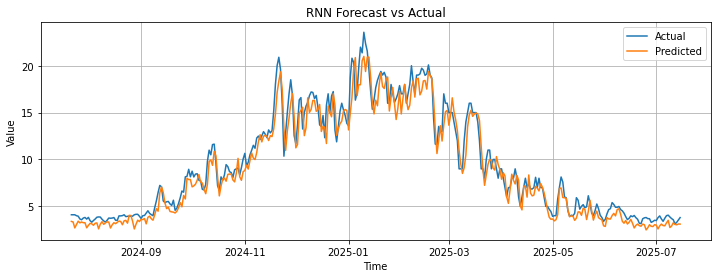

Future data available. Predicting future values...
RNN Future Forecast:
Applicable For
2025-07-21 2.584902
2025-07-22 3.969133
dtype: float32
Recent Values :- 
Applicable For
2025-07-19 3.31747
2025-07-20 3.60831
Name: Demand_D+1, dtype: float64
INFO:tensorflow:Assets written to: /tmp/tmpkxfhsmhn/model/data/model/assets
INFO:tensorflow:Assets written to: /tmp/tmpkxfhsmhn/model/data/model/assets
Could not mirror MLflow artifacts: An error occurred while calling z:com.databricks.backend.daemon.dbutils.FSUtils.cp.
: com.databricks.backend.daemon.data.common.InvalidMountException: Error while using path /databricks/mlflow-tracking/df9dbe2254e646bfb487221c767bd67b/c065ca169d5c4712b54a9056c3828a56/artifacts for resolving path '/df9dbe2254e646bfb487221c767bd67b/c065ca169d5c4712b54a9056c3828a56/artifacts' within mount at '/databricks/mlflow-tracking'.
	at com.databricks.backend.daemon.data.common.InvalidMountException$.apply(DataMessages.scala:682)
	at com.databricks.backend.daemon.data.filesystem.MountEntryResolver.resolve(MountEntryResolver.scala:96)
	at com.databricks.backend.daemon.data.client.DBFSV2.resolve(DatabricksFileSystemV2.scala:81)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.$anonfun$getFileStatus$2(DatabricksFileSystemV2.scala:866)
	at com.databricks.s3a.S3AExceptionUtils$.convertAWSExceptionToJavaIOException(DatabricksStreamUtils.scala:70)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.$anonfun$getFileStatus$1(DatabricksFileSystemV2.scala:865)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:330)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:425)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:445)
	at com.databricks.logging.Log4jUsageLoggingShim$.$anonfun$withAttributionContext$1(Log4jUsageLoggingShim.scala:33)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:94)
	at com.databricks.logging.Log4jUsageLoggingShim$.withAttributionContext(Log4jUsageLoggingShim.scala:31)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:205)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:204)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.withAttributionContext(DatabricksFileSystemV2.scala:510)
	at com.databricks.logging.UsageLogging.withAttributionTags(UsageLogging.scala:240)
	at com.databricks.logging.UsageLogging.withAttributionTags$(UsageLogging.scala:225)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.withAttributionTags(DatabricksFileSystemV2.scala:510)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags(UsageLogging.scala:420)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags$(UsageLogging.scala:339)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.recordOperationWithResultTags(DatabricksFileSystemV2.scala:510)
	at com.databricks.logging.UsageLogging.recordOperation(UsageLogging.scala:330)
	at com.databricks.logging.UsageLogging.recordOperation$(UsageLogging.scala:302)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.recordOperation(DatabricksFileSystemV2.scala:510)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.getFileStatus(DatabricksFileSystemV2.scala:865)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystem.getFileStatus(DatabricksFileSystem.scala:215)
	at com.databricks.backend.daemon.dbutils.FSUtils$.$anonfun$withCpSafetyChecks$2(DBUtilsCore.scala:102)
	at com.databricks.backend.daemon.dbutils.FSUtils$.withFsSafetyCheck(DBUtilsCore.scala:91)
	at com.databricks.backend.daemon.dbutils.FSUtils$.$anonfun$withCpSafetyChecks$1(DBUtilsCore.scala:98)
	at com.databricks.backend.daemon.dbutils.FSUtils$.withFsSafetyCheck(DBUtilsCore.scala

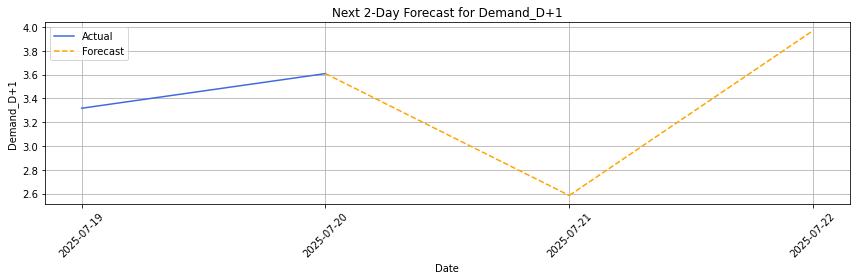

(<__main__.GasModel at 0x7fc5f423a1f0>,
 <keras.engine.sequential.Sequential at 0x7fc5f42660d0>,
 MinMaxScaler(),
 MinMaxScaler(),
 Applicable For
 2025-07-21 2.584902
 2025-07-22 3.969133
 dtype: float32)

In [0]:
rnn_forecaster = GasModel()


rnn_forecaster.train_dlm(
    file_path=master_data_path_dbfs,
    target="Demand_D+1",
    target_shift=1,
    feature_cols=["Temp_Fo_D-1(C)", "CWV_D-1"],
    #feature_cols=["Temp_Fo_D-1(C)", "CWV_D-1", "SAP_Actual_Day",
    #"SAP_7D_RAVG", "SAP_30D_RAVG", "Calorific_Value"],
    split_ratio=0.8,
    sequence_length=30,
    units=64,
    epochs=30,
    batch_size=32,
    dense=1,
    random_seed=42,
    forecast_after_train=True,
    fix_nan=True,
    optimizer='adam',
    loss='mse',
    use_mlflow=True,
    flow_num=1,
    tag="RNN_Bi_Test",
    DLM="RNN"
)


CALL LSTM MODEL

Data Summary (target = Demand_D+1)
Train Range : 2020-07-21 00:00:00 to 2024-07-19 00:00:00 (1460 rows)
Test Range : 2024-07-20 00:00:00 to 2025-07-15 00:00:00 (361 rows)
Future Forecast Range : 2025-07-21 00:00:00 to 2025-07-22 00:00:00 (2 rows)
Final features used in LSTM: ['Temp_Fo_D-1(C)', 'CWV_D-1', 'Calorific_Value', 'Target_Shift_Ac', 'day_of_week', 'month_of_year']
DataFrame columns before normalization ['Demand_D+1', 'Demand_D+6', 'Calorific_Value', 'CWV_D-1', 'CWV_D', 'CWV_D+1', 'SAP_Actual_Day', 'SAP_Highest_18', 'SAP_7D_RAVG', 'SAP_30D_RAVG', 'Temp_Ac_D+1(C)', 'Temp_Fo_D(C)', 'Temp_Fo_D-1(C)', 'Temp_SN_D(C)', 'Temp_SN_D+1(C)', 'Temp_SN_D-1(C)', 'Target_Shift_Ac', 'day_of_week', 'month_of_year']
Epoch 1/30
 1/45 [..............................] - ETA: 1:27 - loss: 0.2038 4/45 [=>............................] - ETA: 0s - loss: 0.1466  8/45 [====>.........................] - ETA: 0s - loss: 0.112011/45 [======>.......................] - ETA: 0s - loss: 0.098915/45 [=========>....................] - ETA: 0s - loss: 0.081719/45 [===========>..................] - ETA: 0s - loss: 0.070523/45 [==============>...............] - ETA: 0s - loss: 0.060727/45 [=================>............] - ETA: 0s - loss: 0.053231/45 [===================>..........] - ETA: 0s - loss: 0.048234/45 [=====================>........] - ETA: 0s - loss: 0.045038/45 [========================>.....] - ETA: 0s - loss: 0.041242/45 [===========================>..] - ETA: 0s - loss: 0.038045/45 [==============================] - ETA: 0s - loss: 0.036545/45 [==============================] - 3s 17ms/step - loss: 0.0365
Epoch 2/30
 1/45 [..............................] - ETA: 0s - loss: 0.0121 5/45 [==>...........................] - ETA: 0s - loss: 0.0088 9/45 [=====>........................] - ETA: 0s - loss: 0.008513/45 [=======>......................] - ETA: 0s - loss: 0.007716/45 [=========>....................] - ETA: 0s - loss: 0.008519/45 [===========>..................] - ETA: 0s - loss: 0.008223/45 [==============>...............] - ETA: 0s - loss: 0.008026/45 [================>.............] - ETA: 0s - loss: 0.007929/45 [==================>...........] - ETA: 0s - loss: 0.008133/45 [=====================>........] - ETA: 0s - loss: 0.007737/45 [=======================>......] - ETA: 0s - loss: 0.007840/45 [=========================>....] - ETA: 0s - loss: 0.007844/45 [====

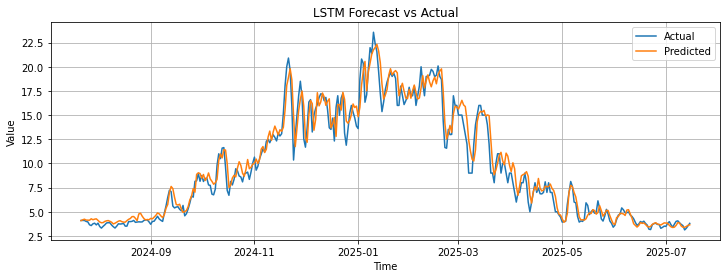

Future data available. Predicting future values...
LSTM Future Forecast:
Applicable For
2025-07-21 3.718387
2025-07-22 3.566900
dtype: float32
Recent Values :- 
Applicable For
2025-07-19 3.31747
2025-07-20 3.60831
Name: Demand_D+1, dtype: float64
WARNING:absl:Found untraced functions such as lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /tmp/tmpfv8opem3/model/data/model/assets
INFO:tensorflow:Assets written to: /tmp/tmpfv8opem3/model/data/model/assets
WARNING:absl:<keras.layers.recurrent.LSTMCell object at 0x7fc5f40f92e0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
Could not mirror MLflow artifacts: An error occurred while calling z:com.databricks.backend.daemon.dbutils.FSUtils.cp.
: com.databricks.backend.daemon.data.common.InvalidMountException: Error while using path /databricks/mlflow-tracking/df9dbe2254e646bfb487221c767bd67b/265225e4e9c74aebbe552cfed227a0be/artifacts for resolving path '/df9dbe2254e646bfb487221c767bd67b/265225e4e9c74aebbe552cfed227a0be/artifacts' within mount at '/databricks/mlflow-tracking'.
	at com.databricks.backend.daemon.data.common.InvalidMountException$.apply(DataMessages.scala:682)
	at com.databricks.backend.daemon.data.filesystem.MountEntryResolver.resolve(MountEntryResolver.scala:96)
	at com.databricks.backend.daemon.data.client.DBFSV2.resolve(DatabricksFileSystemV2.scala:81)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.$anonfun$getFileStatus$2(DatabricksFileSystemV2.scala:866)
	at com.databricks.s3a.S3AExceptionUtils$.convertAWSExceptionToJavaIOException(DatabricksStreamUtils.scala:70)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.$anonfun$getFileStatus$1(DatabricksFileSystemV2.scala:865)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:330)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:425)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:445)
	at com.databricks.logging.Log4jUsageLoggingShim$.$anonfun$withAttributionContext$1(Log4jUsageLoggingShim.scala:33)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:94)
	at com.databricks.logging.Log4jUsageLoggingShim$.withAttributionContext(Log4jUsageLoggingShim.scala:31)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:205)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:204)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.withAttributionContext(DatabricksFileSystemV2.scala:510)
	at com.databricks.logging.UsageLogging.withAttributionTags(UsageLogging.scala:240)
	at com.databricks.logging.UsageLogging.withAttributionTags$(UsageLogging.scala:225)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.withAttributionTags(DatabricksFileSystemV2.scala:510)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags(UsageLogging.scala:420)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags$(UsageLogging.scala:339)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.recordOperationWithResultTags(DatabricksFileSystemV2.scala:510)
	at com.databricks.logging.UsageLogging.recordOperation(UsageLogging.scala:330)
	at com.databricks.logging.UsageLogging.recordOperation$(UsageLogging.scala:302)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.recordOperation(DatabricksFileSystemV2.scala:510)
	at com.databricks.backend.daem

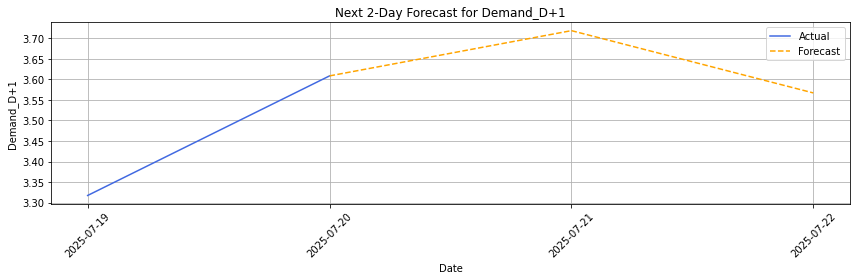

(<__main__.GasModel at 0x7fc69479db80>,
 <keras.engine.sequential.Sequential at 0x7fc6214364f0>,
 MinMaxScaler(),
 MinMaxScaler(),
 Applicable For
 2025-07-21 3.718387
 2025-07-22 3.566900
 dtype: float32)

In [0]:
lstm_forecaster = GasModel()


lstm_forecaster.train_dlm(
    file_path=master_data_path_dbfs,
    target="Demand_D+1",
    target_shift=1,
    feature_cols=["Temp_Fo_D-1(C)", "CWV_D-1","Calorific_Value"],
    #feature_cols=["Temp_Fo_D-1(C)", "CWV_D-1", "SAP_Actual_Day",
    #"SAP_7D_RAVG", "SAP_30D_RAVG", "Calorific_Value"],
    split_ratio=0.8,
    sequence_length=30,
    units=64,
    epochs=30,
    batch_size=32,
    dense=1,
    random_seed=42,
    forecast_after_train=True,
    fix_nan=True,
    optimizer='adam',
    loss='mse',
    use_mlflow=True,
    flow_num=1,
    tag="LSTM_Bi_Test",
    DLM="LSTM"
)

CALL GRU

Data Summary (target = Demand_D+1)
Train Range : 2020-07-21 00:00:00 to 2024-07-19 00:00:00 (1460 rows)
Test Range : 2024-07-20 00:00:00 to 2025-07-15 00:00:00 (361 rows)
Future Forecast Range : 2025-07-21 00:00:00 to 2025-07-22 00:00:00 (2 rows)
Final features used in GRU: ['Temp_Fo_D-1(C)', 'CWV_D-1', 'Calorific_Value', 'Target_Shift_Ac', 'day_of_week', 'month_of_year']
DataFrame columns before normalization ['Demand_D+1', 'Demand_D+6', 'Calorific_Value', 'CWV_D-1', 'CWV_D', 'CWV_D+1', 'SAP_Actual_Day', 'SAP_Highest_18', 'SAP_7D_RAVG', 'SAP_30D_RAVG', 'Temp_Ac_D+1(C)', 'Temp_Fo_D(C)', 'Temp_Fo_D-1(C)', 'Temp_SN_D(C)', 'Temp_SN_D+1(C)', 'Temp_SN_D-1(C)', 'Target_Shift_Ac', 'day_of_week', 'month_of_year']
Epoch 1/30
 1/45 [..............................] - ETA: 1:34 - loss: 0.1510 4/45 [=>............................] - ETA: 0s - loss: 0.1085  8/45 [====>.........................] - ETA: 0s - loss: 0.088411/45 [======>.......................] - ETA: 0s - loss: 0.077915/45 [=========>....................] - ETA: 0s - loss: 0.065318/45 [===========>..................] - ETA: 0s - loss: 0.058822/45 [=============>................] - ETA: 0s - loss: 0.050725/45 [===============>..............] - ETA: 0s - loss: 0.045928/45 [=================>............] - ETA: 0s - loss: 0.041531/45 [===================>..........] - ETA: 0s - loss: 0.038434/45 [=====================>........] - ETA: 0s - loss: 0.035737/45 [=======================>......] - ETA: 0s - loss: 0.033340/45 [=========================>....] - ETA: 0s - loss: 0.031444/45 [============================>.] - ETA: 0s - loss: 0.029345/45 [==============================] - 3s 18ms/step - loss: 0.0289
Epoch 2/30
 1/45 [..............................] - ETA: 0s - loss: 0.0068 5/45 [==>...........................] - ETA: 0s - loss: 0.0056 8/45 [====>.........................] - ETA: 0s - loss: 0.006411/45 [======>.......................] - ETA: 0s - loss: 0.005814/45 [========>.....................] - ETA: 0s - loss: 0.006218/45 [===========>..................] - ETA: 0s - loss: 0.006321/45 [=============>................] - ETA: 0s - loss: 0.006124/45 [===============>..............] - ETA: 0s - loss: 0.006127/45 [=================>............] - ETA: 0s - loss: 0.005830/45 [===================>..........] - ETA: 0s - loss: 0.005834/45 [=====================>........] - ETA: 0s - loss: 0.005638/45 [=====

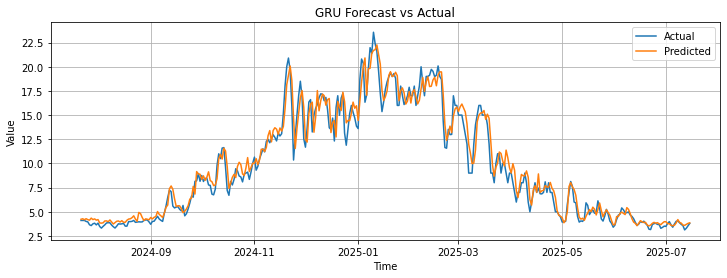

Future data available. Predicting future values...
GRU Future Forecast:
Applicable For
2025-07-21 3.764279
2025-07-22 3.741175
dtype: float32
Recent Values :- 
Applicable For
2025-07-19 3.31747
2025-07-20 3.60831
Name: Demand_D+1, dtype: float64
WARNING:absl:Found untraced functions such as gru_cell_1_layer_call_fn, gru_cell_1_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /tmp/tmpwe3bkzlt/model/data/model/assets
INFO:tensorflow:Assets written to: /tmp/tmpwe3bkzlt/model/data/model/assets
WARNING:absl:<keras.layers.recurrent.GRUCell object at 0x7fc6948b6490> has the same name 'GRUCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.GRUCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
Could not mirror MLflow artifacts: An error occurred while calling z:com.databricks.backend.daemon.dbutils.FSUtils.cp.
: com.databricks.backend.daemon.data.common.InvalidMountException: Error while using path /databricks/mlflow-tracking/df9dbe2254e646bfb487221c767bd67b/ebd0f05472ea4c129bbd58410304551c/artifacts for resolving path '/df9dbe2254e646bfb487221c767bd67b/ebd0f05472ea4c129bbd58410304551c/artifacts' within mount at '/databricks/mlflow-tracking'.
	at com.databricks.backend.daemon.data.common.InvalidMountException$.apply(DataMessages.scala:682)
	at com.databricks.backend.daemon.data.filesystem.MountEntryResolver.resolve(MountEntryResolver.scala:96)
	at com.databricks.backend.daemon.data.client.DBFSV2.resolve(DatabricksFileSystemV2.scala:81)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.$anonfun$getFileStatus$2(DatabricksFileSystemV2.scala:866)
	at com.databricks.s3a.S3AExceptionUtils$.convertAWSExceptionToJavaIOException(DatabricksStreamUtils.scala:70)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.$anonfun$getFileStatus$1(DatabricksFileSystemV2.scala:865)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:330)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:425)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:445)
	at com.databricks.logging.Log4jUsageLoggingShim$.$anonfun$withAttributionContext$1(Log4jUsageLoggingShim.scala:33)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:94)
	at com.databricks.logging.Log4jUsageLoggingShim$.withAttributionContext(Log4jUsageLoggingShim.scala:31)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:205)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:204)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.withAttributionContext(DatabricksFileSystemV2.scala:510)
	at com.databricks.logging.UsageLogging.withAttributionTags(UsageLogging.scala:240)
	at com.databricks.logging.UsageLogging.withAttributionTags$(UsageLogging.scala:225)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.withAttributionTags(DatabricksFileSystemV2.scala:510)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags(UsageLogging.scala:420)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags$(UsageLogging.scala:339)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.recordOperationWithResultTags(DatabricksFileSystemV2.scala:510)
	at com.databricks.logging.UsageLogging.recordOperation(UsageLogging.scala:330)
	at com.databricks.logging.UsageLogging.recordOperation$(UsageLogging.scala:302)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.recordOperation(DatabricksFileSystemV2.scala:510)
	at com.databricks.backend.daemon.dat

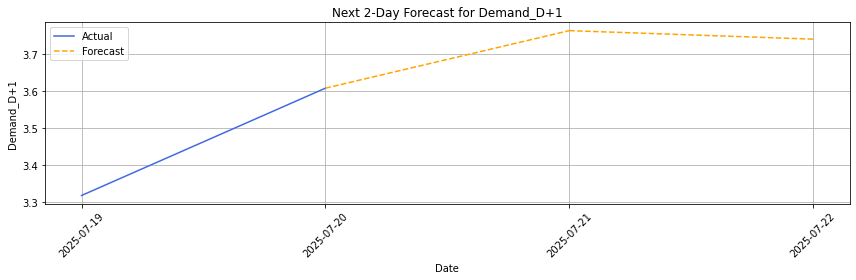

(<__main__.GasModel at 0x7fc6945a3160>,
 <keras.engine.sequential.Sequential at 0x7fc5f441f490>,
 MinMaxScaler(),
 MinMaxScaler(),
 Applicable For
 2025-07-21 3.764279
 2025-07-22 3.741175
 dtype: float32)

In [0]:
gru_forecaster = GasModel()


gru_forecaster.train_dlm(
    file_path=master_data_path_dbfs,
    target="Demand_D+1",
    target_shift=1,
    feature_cols=["Temp_Fo_D-1(C)", "CWV_D-1","Calorific_Value"],
    #feature_cols=["Temp_Fo_D-1(C)", "CWV_D-1", "SAP_Actual_Day",
    #"SAP_7D_RAVG", "SAP_30D_RAVG", "Calorific_Value"],
    split_ratio=0.8,
    sequence_length=30,
    units=64,
    epochs=30,
    batch_size=32,
    dense=1,
    random_seed=42,
    forecast_after_train=True,
    fix_nan=True,
    optimizer='adam',
    loss='mse',
    use_mlflow=True,
    flow_num=1,
    tag="GRU_Bi_Test",
    DLM="GRU"
)

CALL FOR SARIMAX

Data Summary (target = Demand_D+1)
Train Range : 2020-07-20 00:00:00 to 2024-07-19 00:00:00 (1461 rows)
Test Range : 2024-07-20 00:00:00 to 2025-07-15 00:00:00 (361 rows)
Future Forecast Range : 2025-07-21 00:00:00 to 2025-07-22 00:00:00 (2 rows)
Exog Train (AC): Temp_Ac_D+1(C) CWV_D+1
Applicable For 
2020-07-20 15.0000 16.25
2020-07-21 15.1000 16.23
2020-07-22 15.3000 16.57
2020-07-23 15.4000 16.63
2020-07-24 15.6000 16.63
... ... ...
2024-07-15 14.5811 15.94
2024-07-16 14.6387 16.12
2024-07-17 15.0380 16.39
2024-07-18 15.2024 16.51
2024-07-19 15.2428 16.51

[1461 rows x 2 columns]
Exog Test (FO): Temp_Fo_D-1(C) CWV_D-1
Applicable For 
2024-07-20 15.2029 16.51
2024-07-21 15.1189 16.51
2024-07-22 15.1514 16.51
2024-07-23 15.1847 16.51
2024-07-24 15.2018 16.51
... ... ...
2025-07-11 15.2669 16.51
2025-07-12 15.2669 16.51
2025-07-13 15.2669 16.51
2025-07-14 15.2669 16.51
2025-07-15 15.1789 16.51

[361 rows x 2 columns]
Exog Future (FO): Temp_Fo_D-1(C) CWV_D-1
Applicable For 
2025-07-21 15.2176 16.50
2025-07-22 15.1776 16.51
SARIMAX model trained.
MAE: 0.62
RMSE: 0.87
MAPE: 0.08

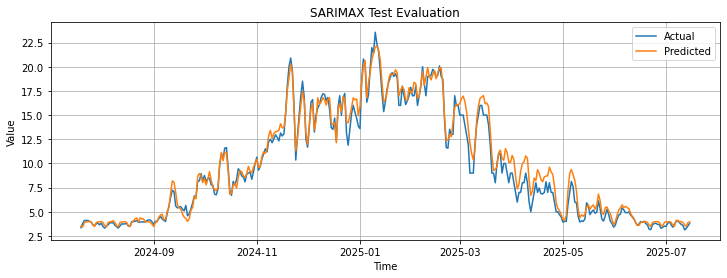

MLflow model logging failed: log_model() missing 1 required positional argument: 'artifact_path'
DatetimeIndex(['2025-07-21', '2025-07-22'], dtype='datetime64[ns]', name='Applicable For', freq=None)
Forecast Values :- 
Applicable For
2025-07-21 3.521835
2025-07-22 3.432749
Name: predicted_mean, dtype: float64
Recent Values :- 
Applicable For
2025-07-19 3.31747
2025-07-20 3.60831
Name: Demand_D+1, dtype: float64
Could not mirror MLflow artifacts: An error occurred while calling z:com.databricks.backend.daemon.dbutils.FSUtils.cp.
: com.databricks.backend.daemon.data.common.InvalidMountException: Error while using path /databricks/mlflow-tracking/df9dbe2254e646bfb487221c767bd67b/3856ddb3b3a2453ebc987688c86a1887/artifacts for resolving path '/df9dbe2254e646bfb487221c767bd67b/3856ddb3b3a2453ebc987688c86a1887/artifacts' within mount at '/databricks/mlflow-tracking'.
	at com.databricks.backend.daemon.data.common.InvalidMountException$.apply(DataMessages.scala:682)
	at com.databricks.backend.daemon.data.filesystem.MountEntryResolver.resolve(MountEntryResolver.scala:96)
	at com.databricks.backend.daemon.data.client.DBFSV2.resolve(DatabricksFileSystemV2.scala:81)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.$anonfun$getFileStatus$2(DatabricksFileSystemV2.scala:866)
	at com.databricks.s3a.S3AExceptionUtils$.convertAWSExceptionToJavaIOException(DatabricksStreamUtils.scala:70)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.$anonfun$getFileStatus$1(DatabricksFileSystemV2.scala:865)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:330)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:425)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:445)
	at com.databricks.logging.Log4jUsageLoggingShim$.$anonfun$withAttributionContext$1(Log4jUsageLoggingShim.scala:33)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:94)
	at com.databricks.logging.Log4jUsageLoggingShim$.withAttributionContext(Log4jUsageLoggingShim.scala:31)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:205)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:204)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.withAttributionContext(DatabricksFileSystemV2.scala:510)
	at com.databricks.logging.UsageLogging.withAttributionTags(UsageLogging.scala:240)
	at com.databricks.logging.UsageLogging.withAttributionTags$(UsageLogging.scala:225)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.withAttributionTags(DatabricksFileSystemV2.scala:510)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags(UsageLogging.scala:420)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags$(UsageLogging.scala:339)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.recordOperationWithResultTags(DatabricksFileSystemV2.scala:510)
	at com.databricks.logging.UsageLogging.recordOperation(UsageLogging.scala:330)
	at com.databricks.logging.UsageLogging.recordOperation$(UsageLogging.scala:302)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.recordOperation(DatabricksFileSystemV2.scala:510)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV2.getFileStatus(DatabricksFileSystemV2.scala:865)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystem.getFileStatus(DatabricksFileSystem.scala:215)
	at com.databricks.backend.daemon.dbutils.FSUtils$.$anonfun$withCpSafetyChecks$2(DBUtilsCore.scala:102)
	at com.databricks.backend.daemon.dbutils.FSUtils$.withFsSafetyCheck(DBUtilsCore.scala:91)
	at com.databricks.backend.daemon.dbutils.FSUtils$.$anonfun$withCpSafetyChecks$1(DBUtilsCore.scala:98)
	at com.databricks.backend.daemon.dbutils.FSUtils$.withFsSafetyCheck(

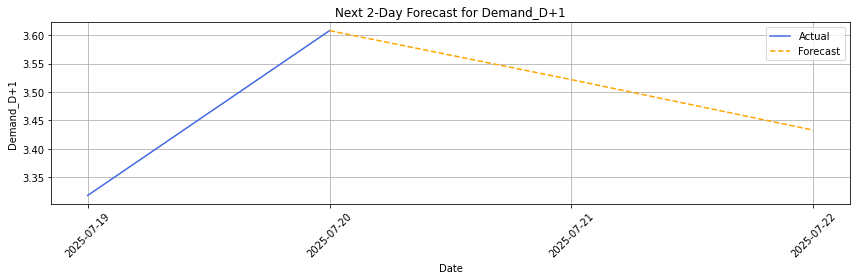

(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fc6942e4520>,
 Applicable For
 2024-07-20 3.510177
 2024-07-21 3.432991
 2024-07-22 3.877086
 2024-07-23 3.954677
 2024-07-24 3.950014
 ... 
 2025-07-11 3.888362
 2025-07-12 3.602046
 2025-07-13 3.510472
 2025-07-14 3.894259
 2025-07-15 3.960401
 Name: predicted_mean, Length: 361, dtype: float64,
 Temp_Fo_D-1(C) CWV_D-1
 Applicable For 
 2025-07-21 15.2176 16.50
 2025-07-22 15.1776 16.51)

In [0]:
sarimax_forecaster = GasModel()
sarimax_forecaster.train_sarimax(
    file_path=master_data_path_dbfs,
    target="Demand_D+1",
    exog_vars= {
        "ac": ["Temp_Ac_D+1(C)", "CWV_D+1"],
        "fo": ["Temp_Fo_D-1(C)", "CWV_D-1"]},
#    exog_vars=["SAP_Actual_Day", "Temp_Ac_D+1(C)", "Temp_Fo_D-1(C)","Calorific_Value", "CWV_D", "CWV_D-1", "CWV_D+1", "SAP_30D_RAVG"],
    auto=False,
    #(2,1,1)(1,0,1)[7] 
    order=(2,1,1),
    seasonal_order=(1,0,1,7),
    ac_fo_mode=True,
    forecaster_after_train=True,
    split_ratio=0.8,
    fix_nan=True,
    use_mlflow=True,
    flow_num=1,
    tag="SARIMAX_Bi_Test"
)

